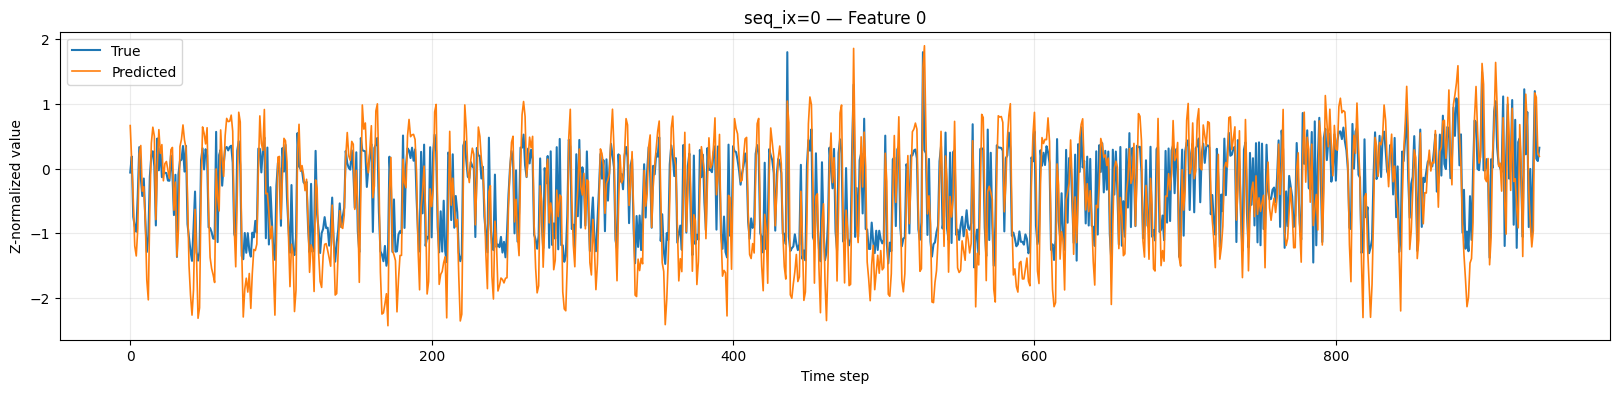

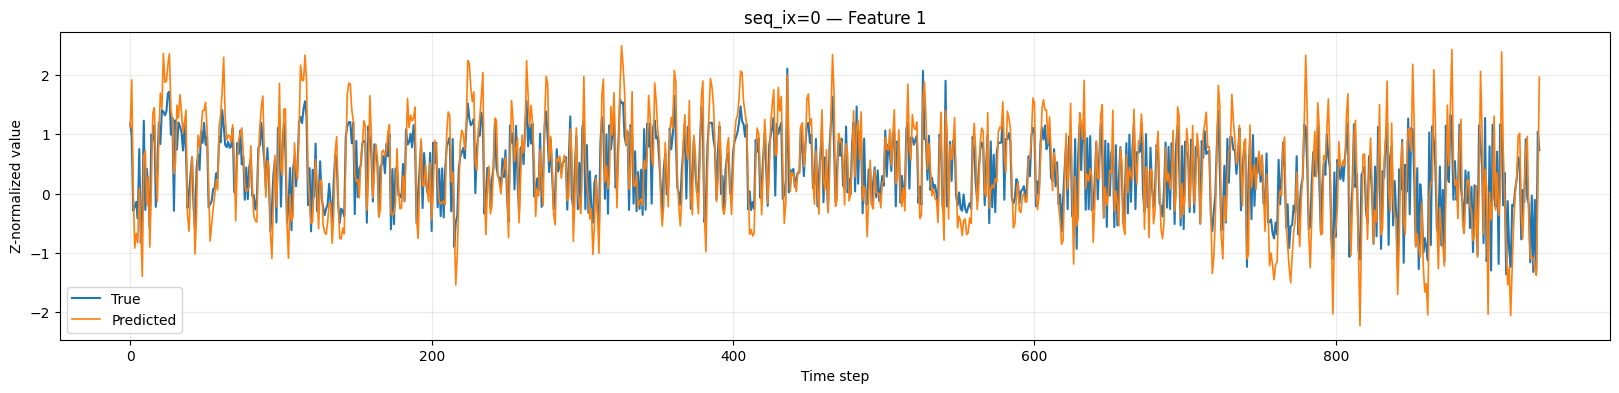

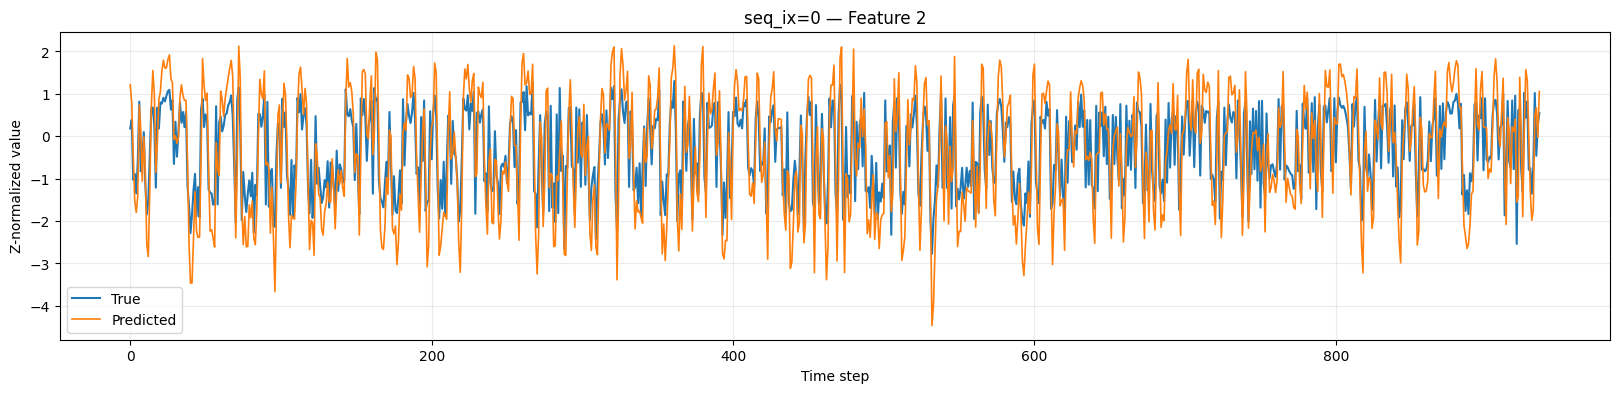

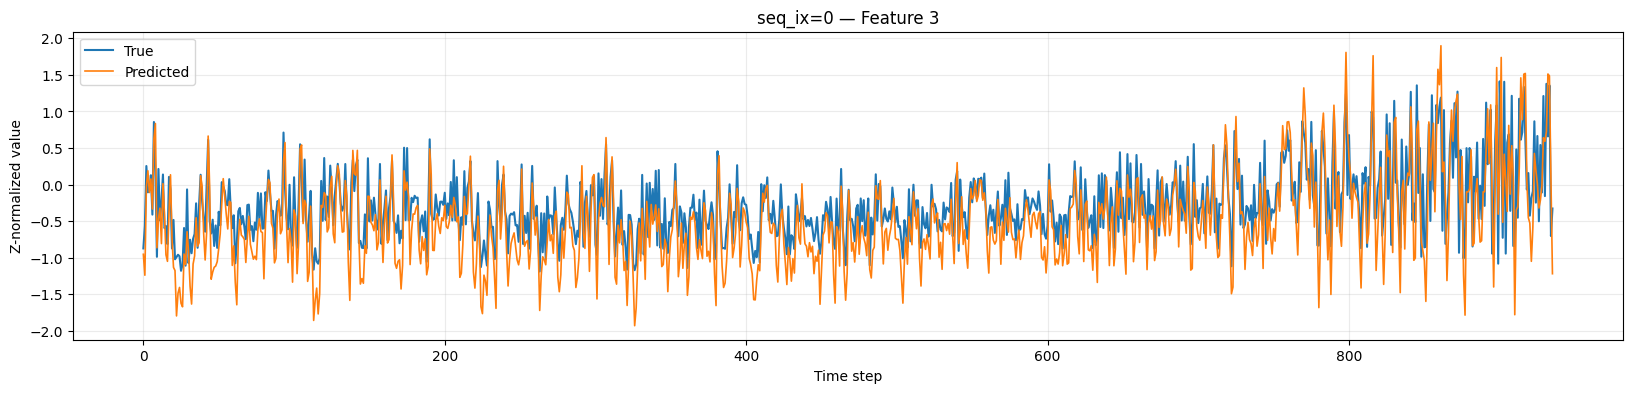

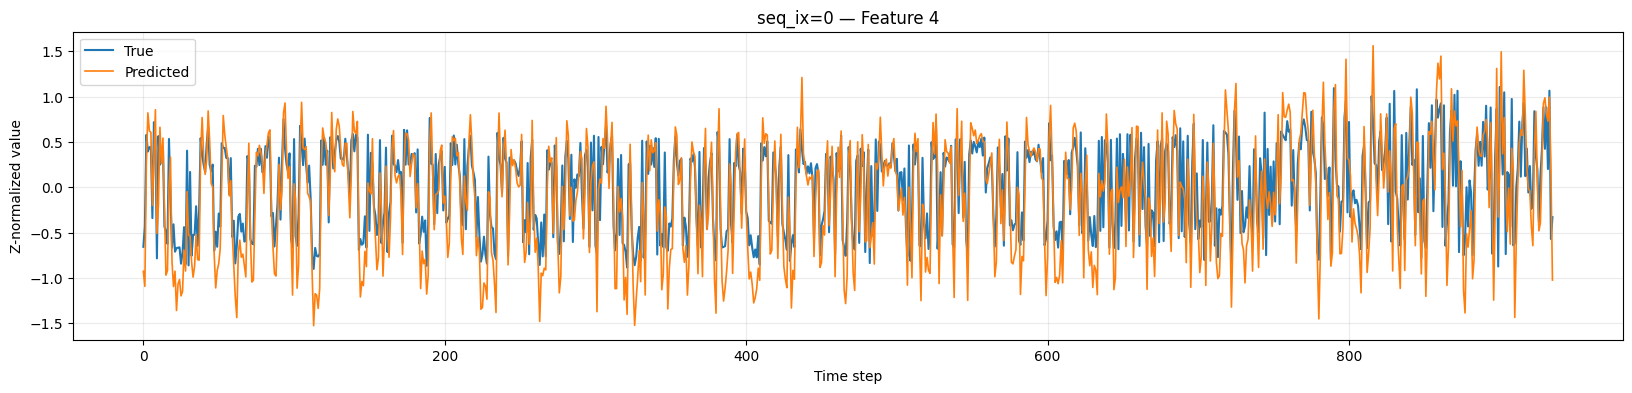

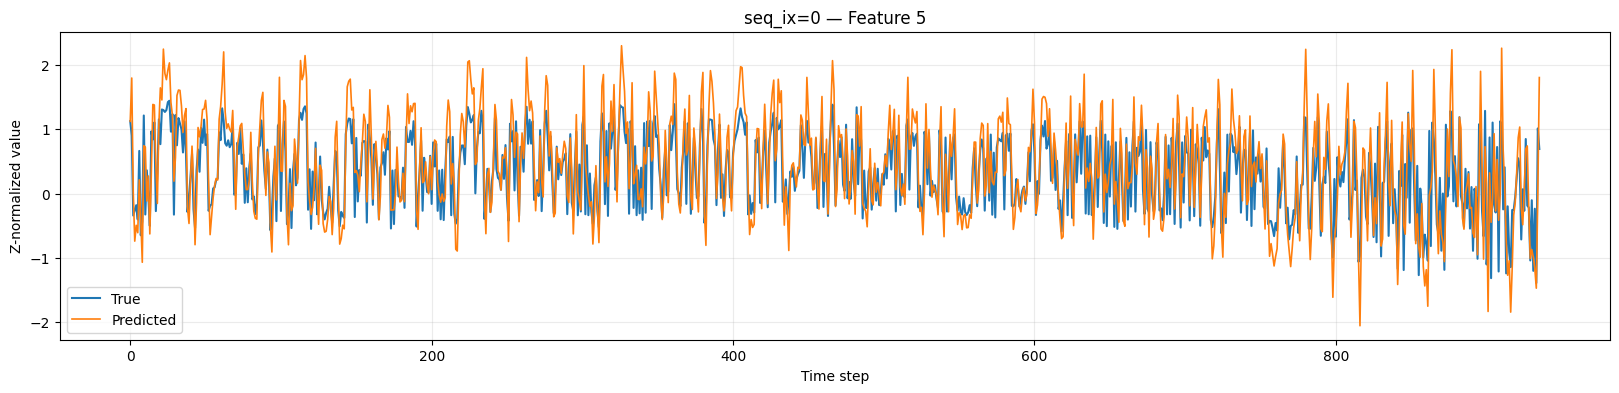

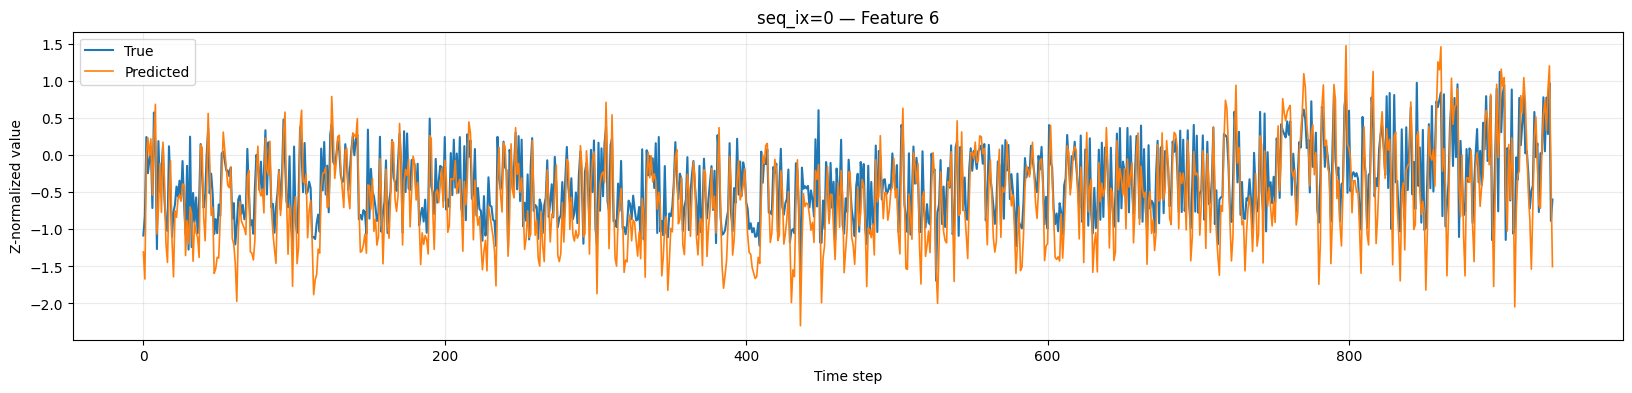

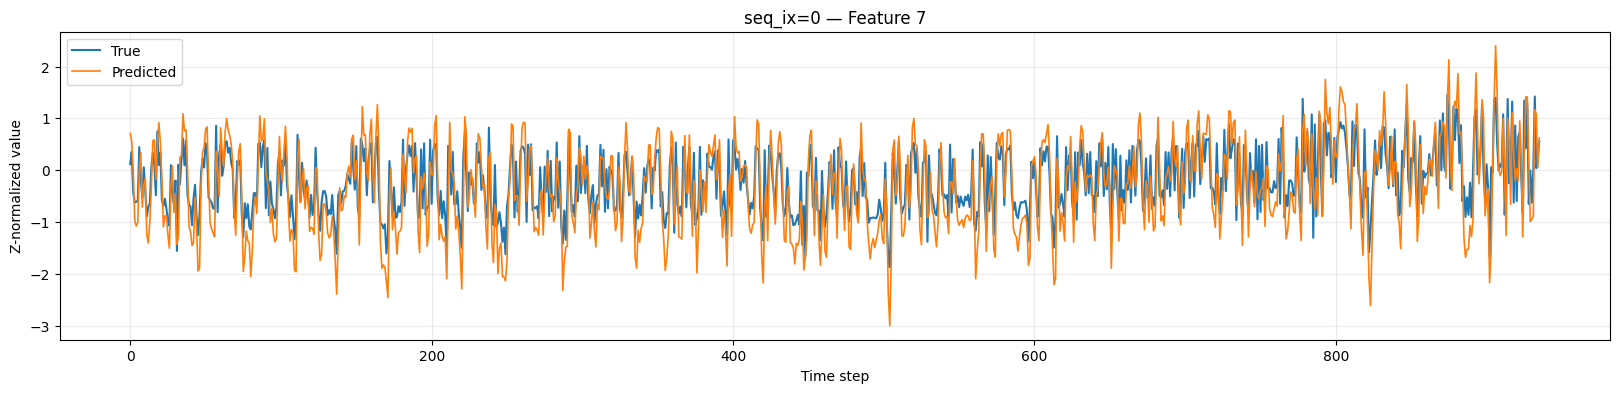

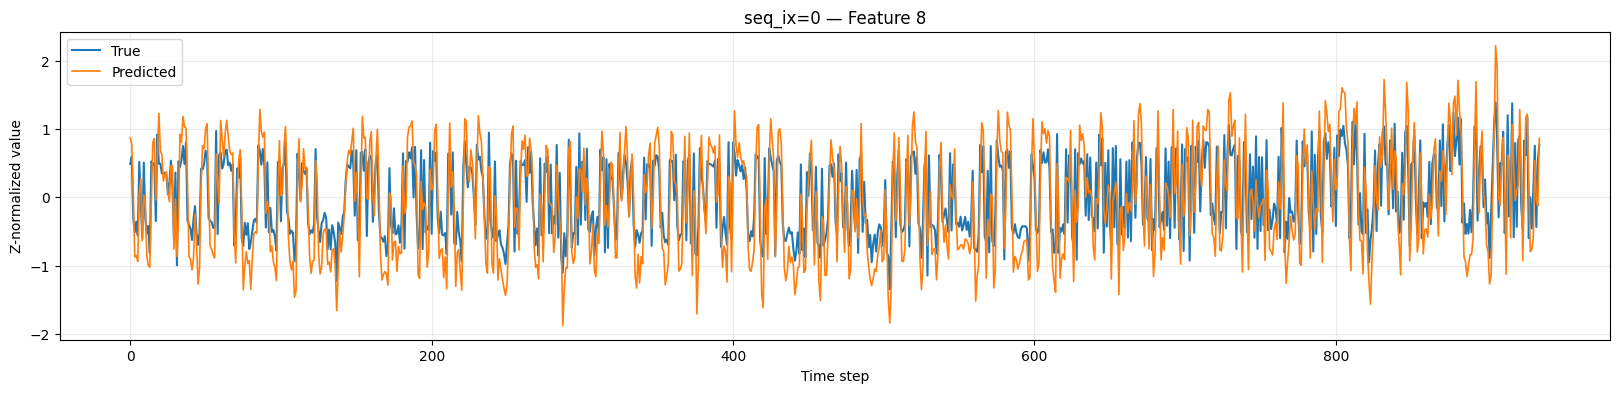

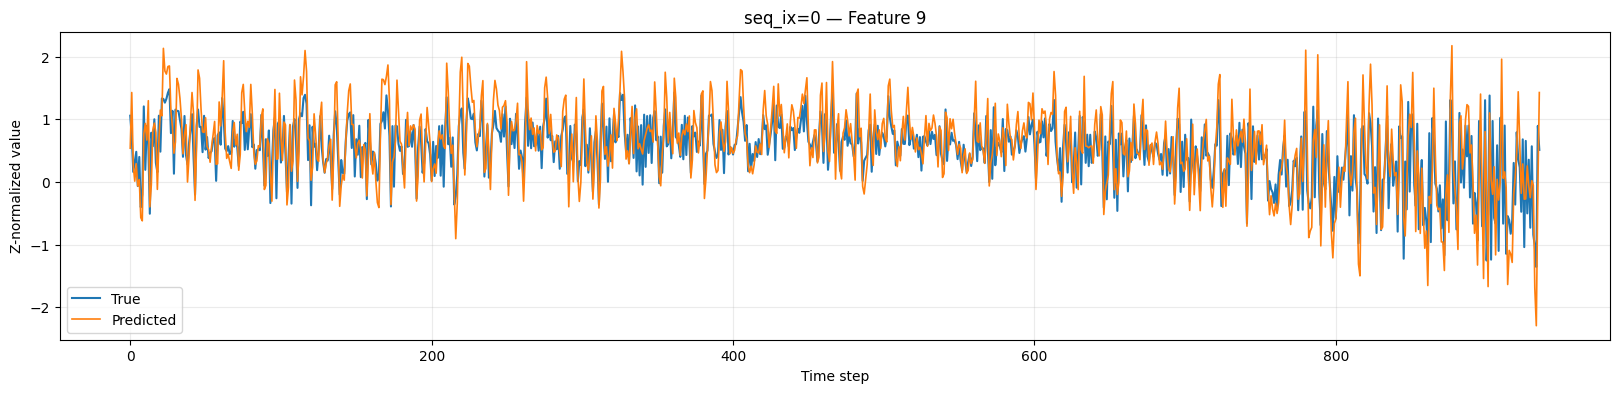

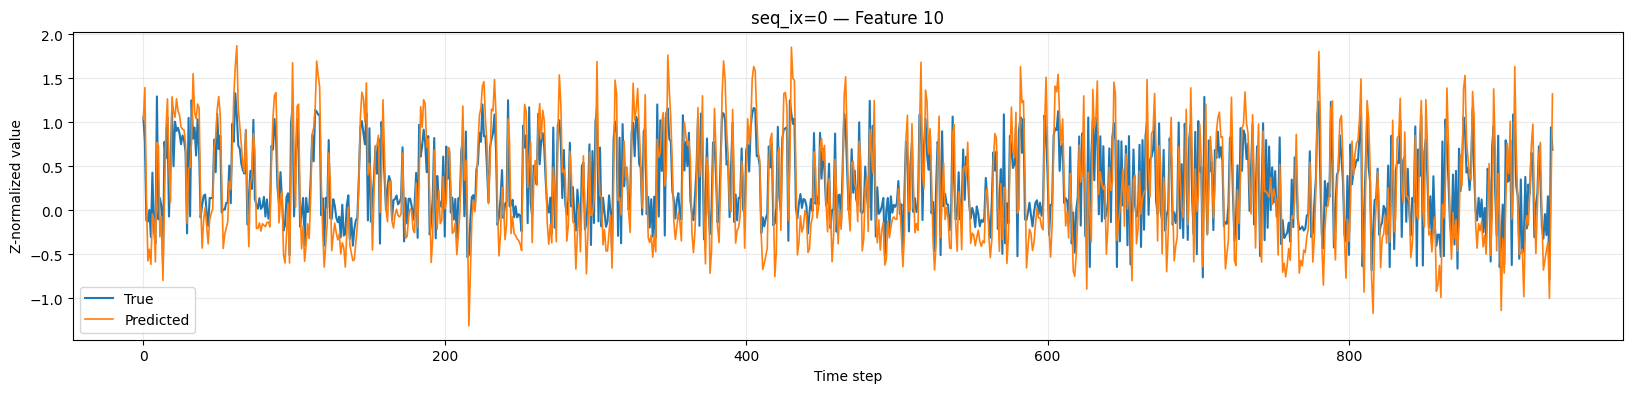

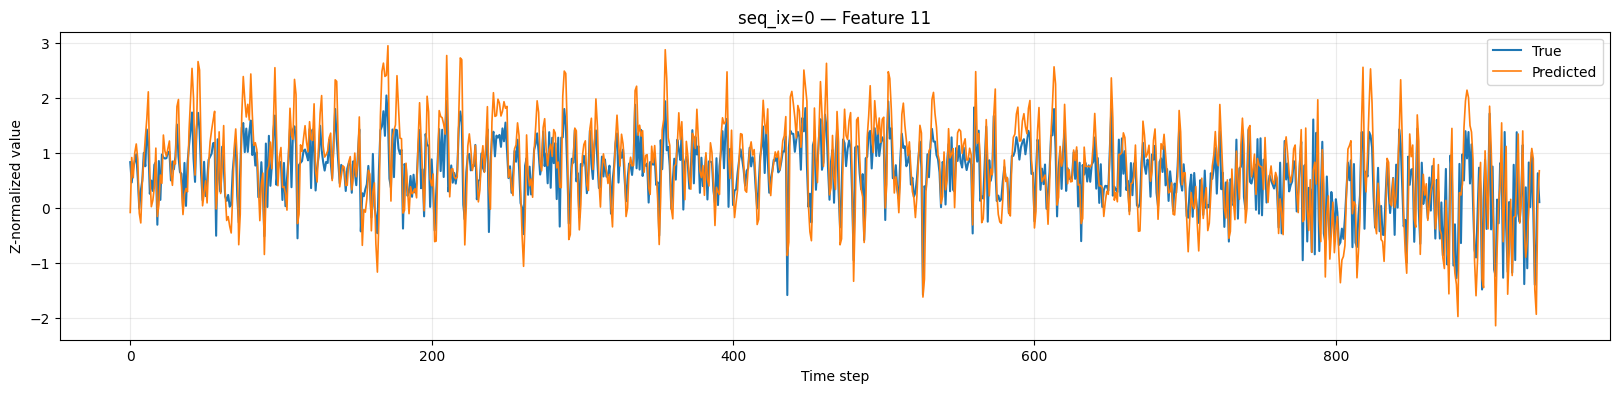

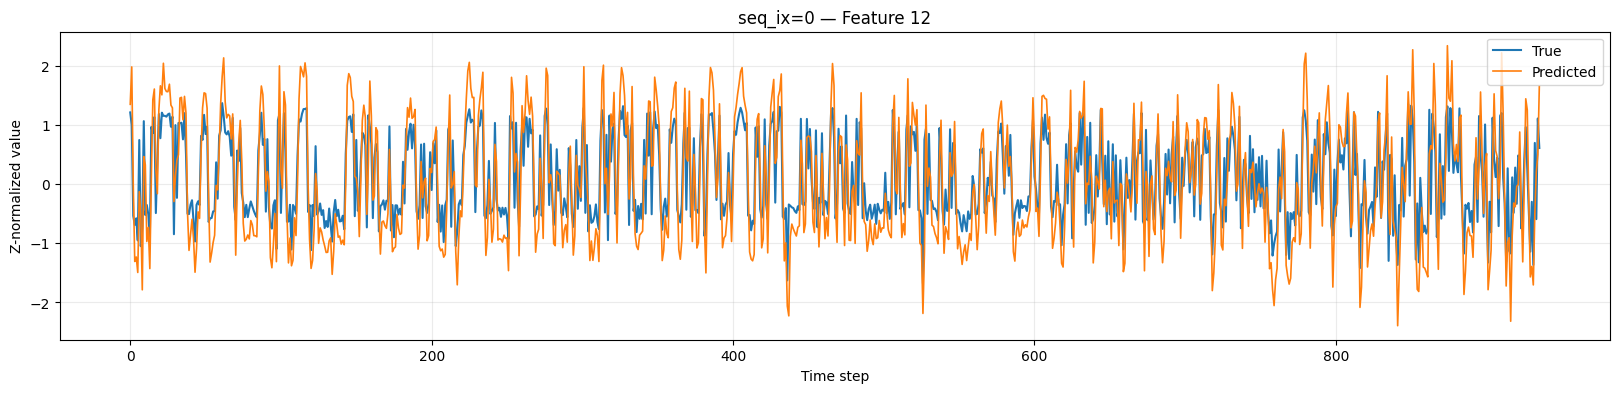

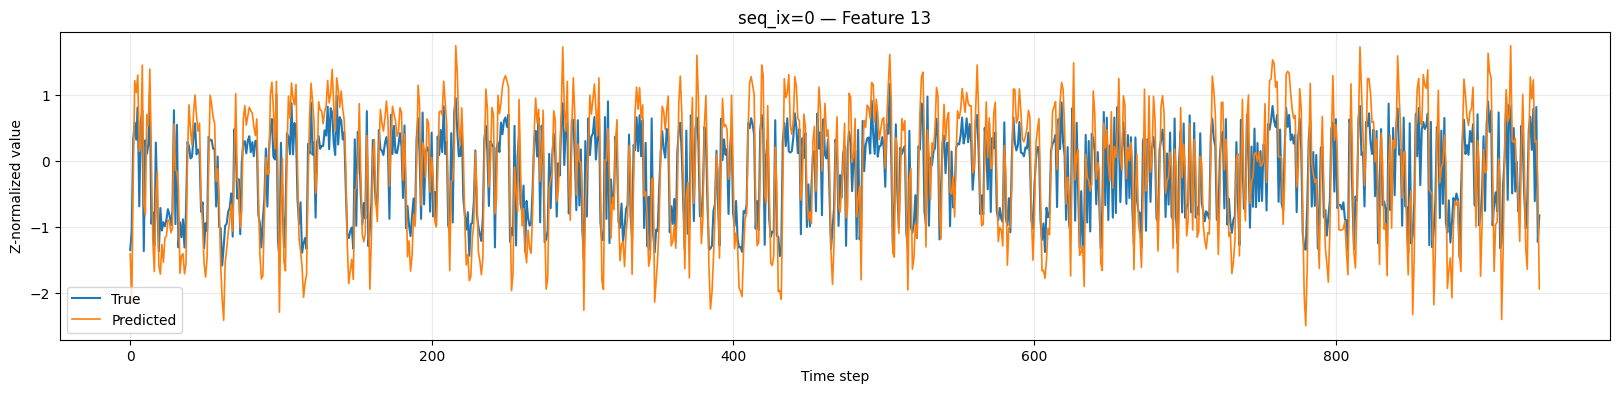

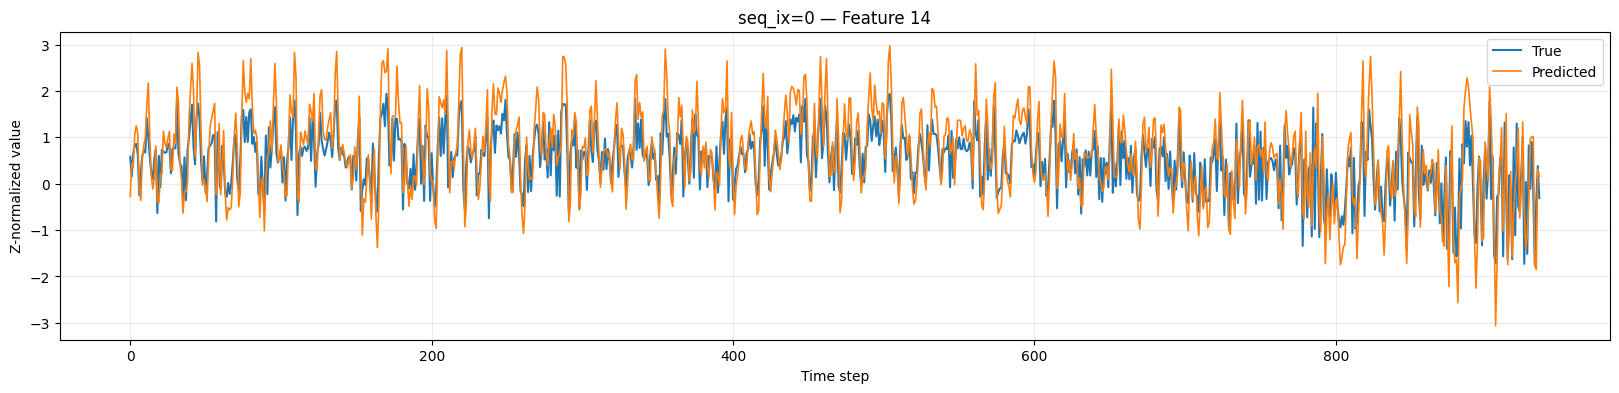

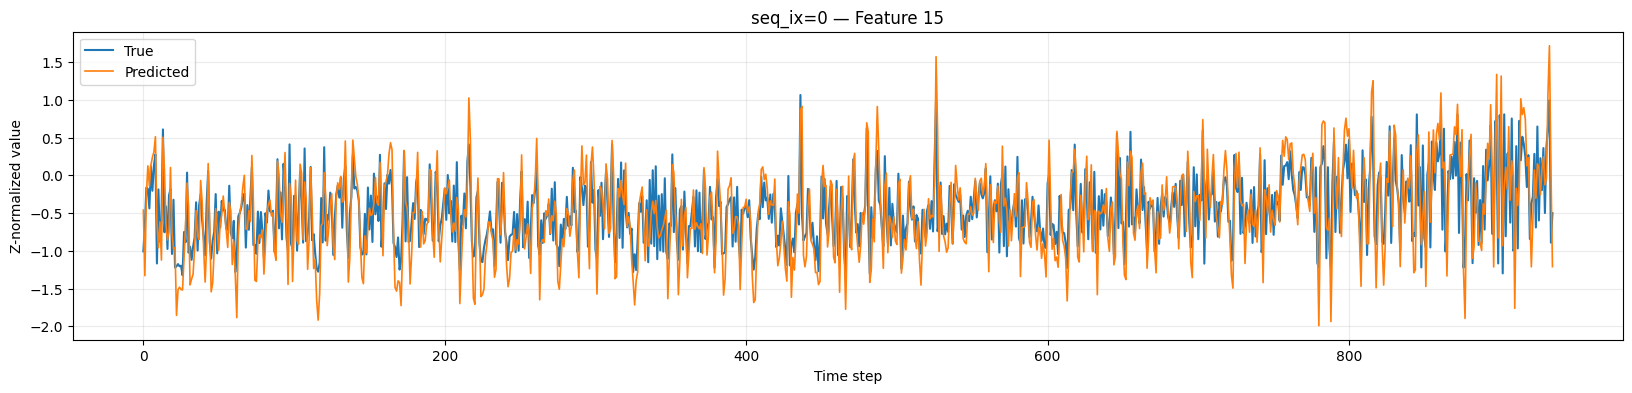

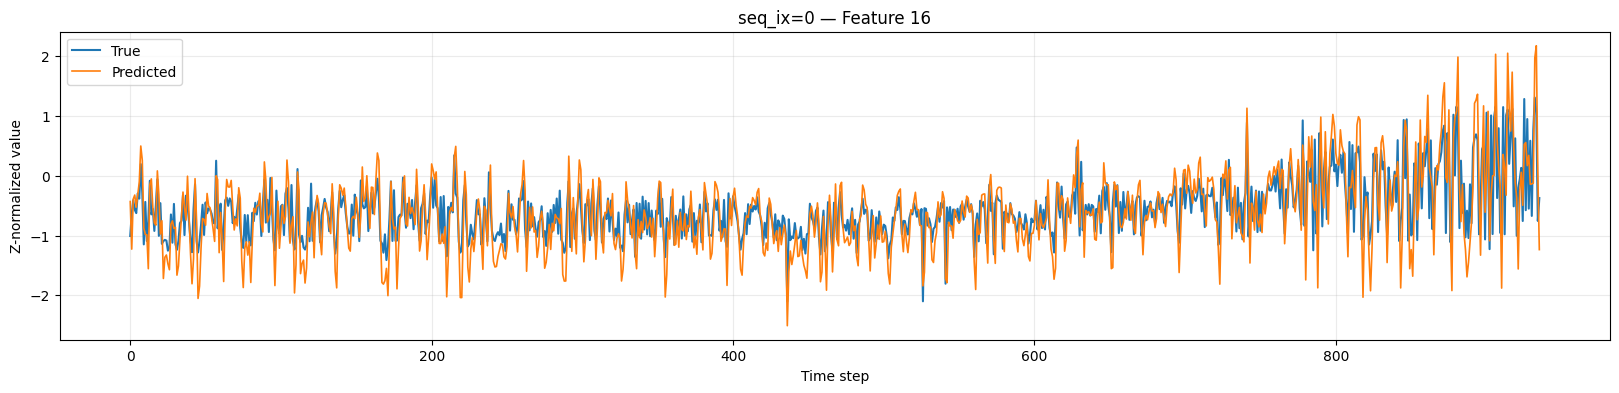

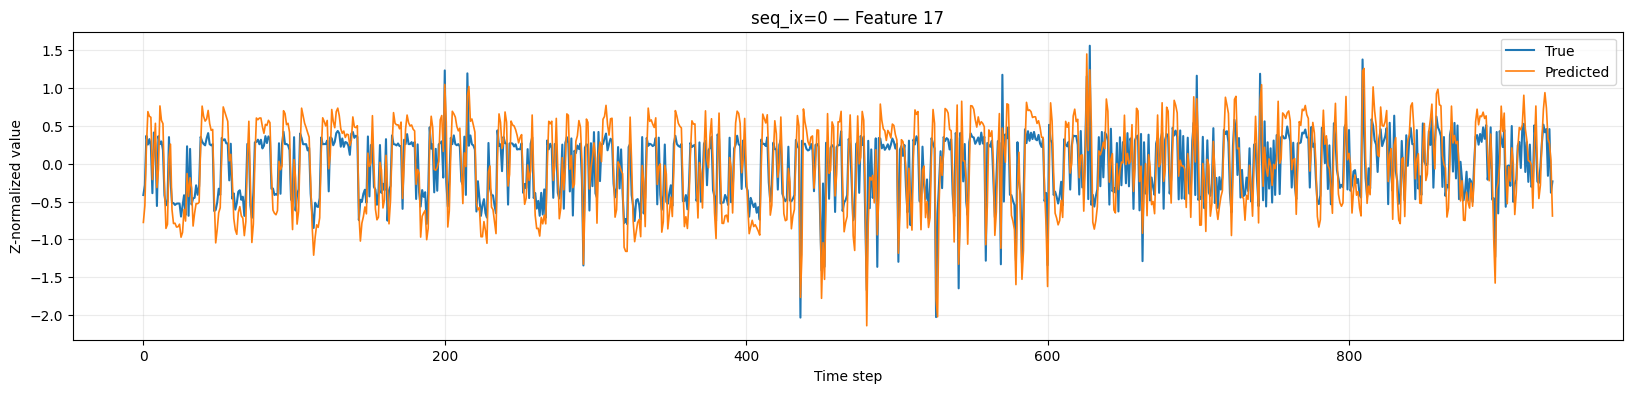

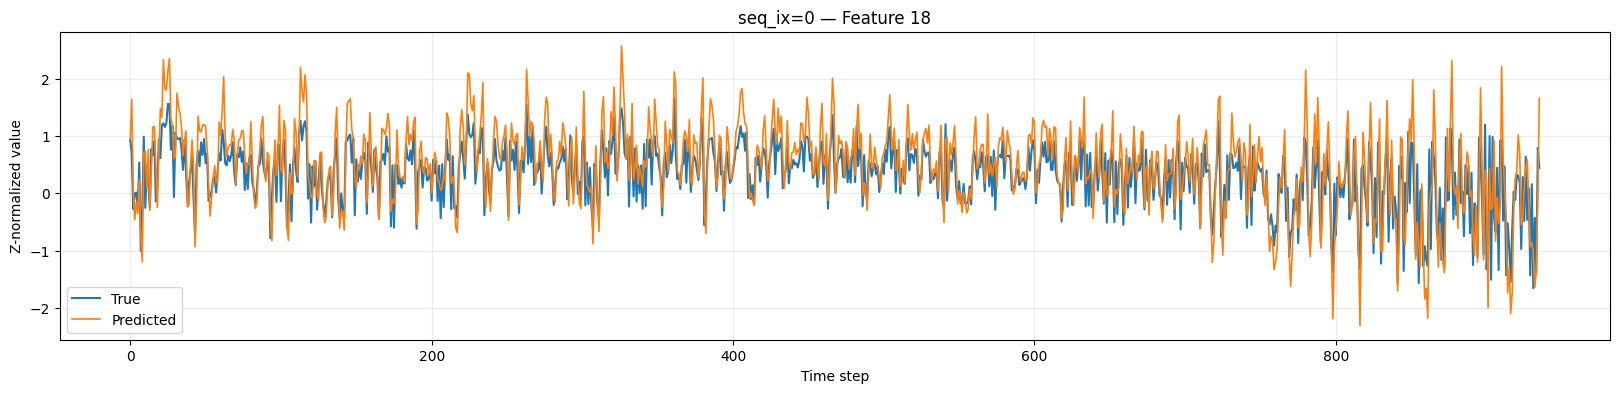

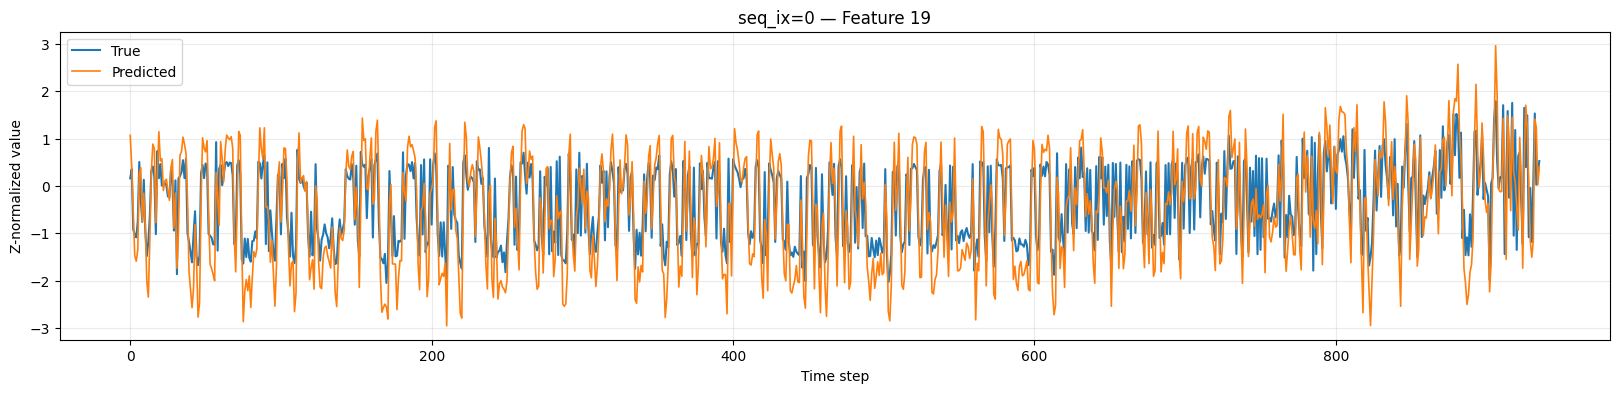

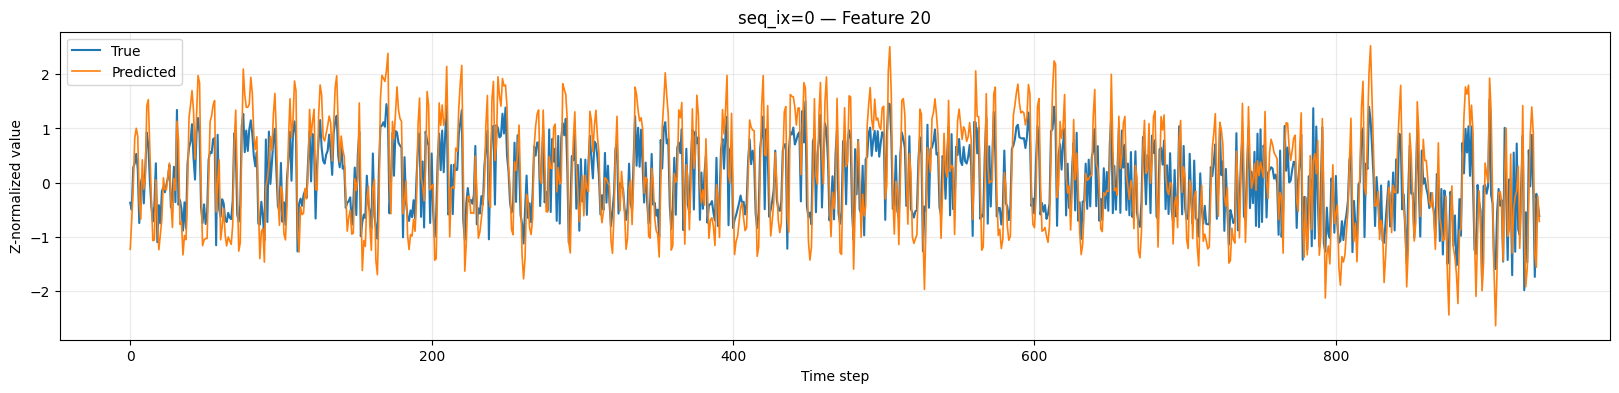

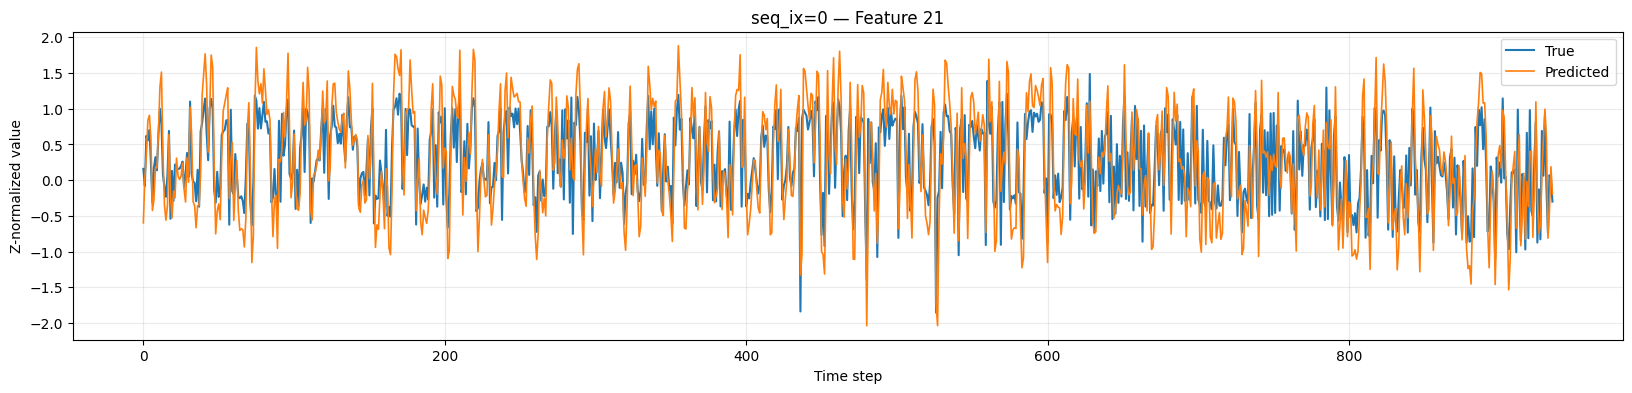

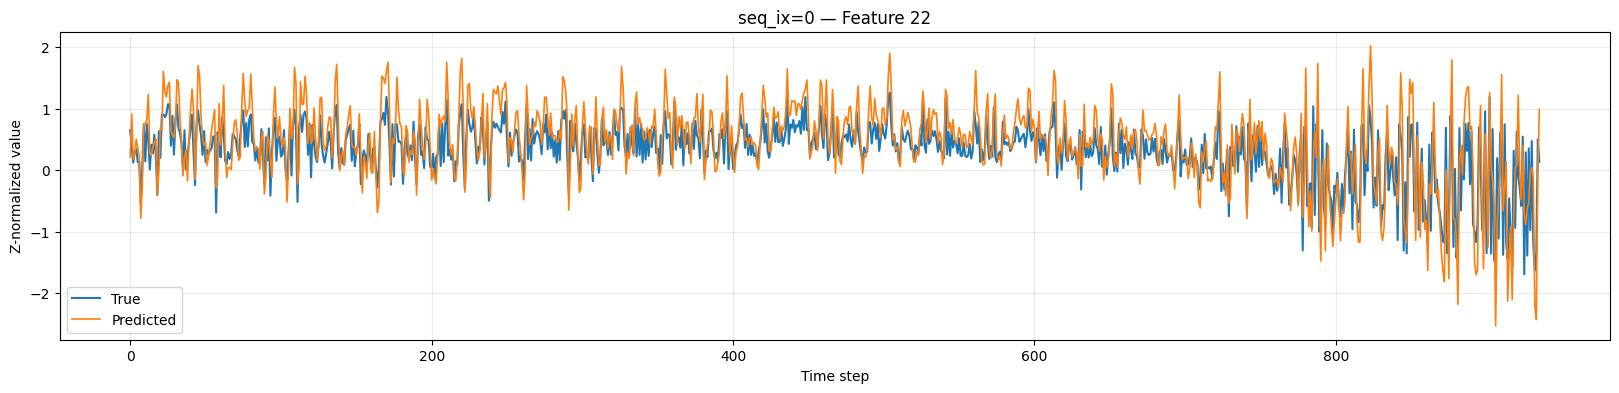

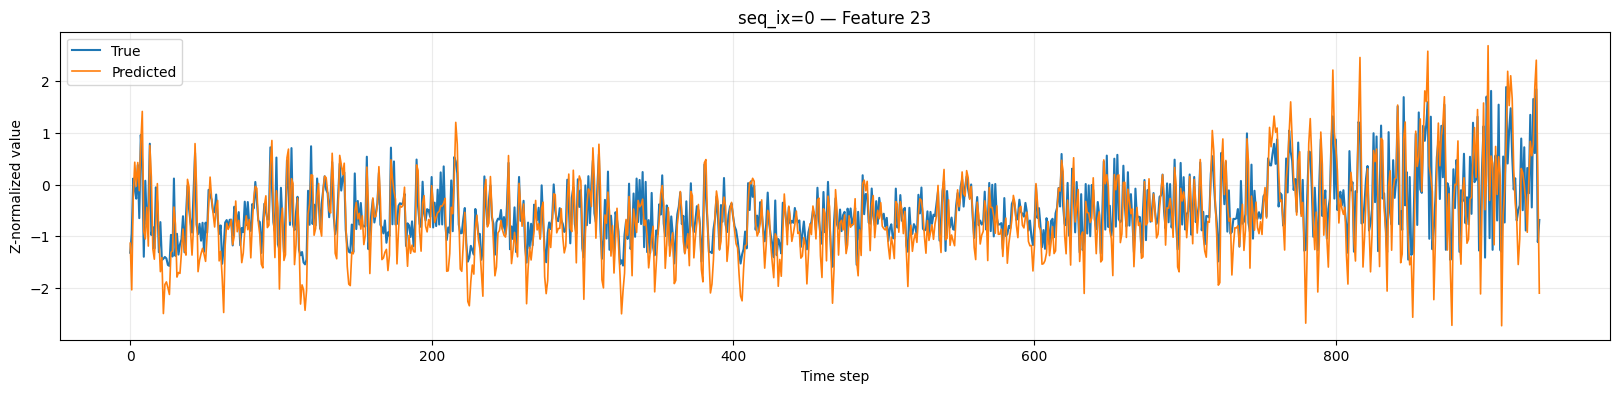

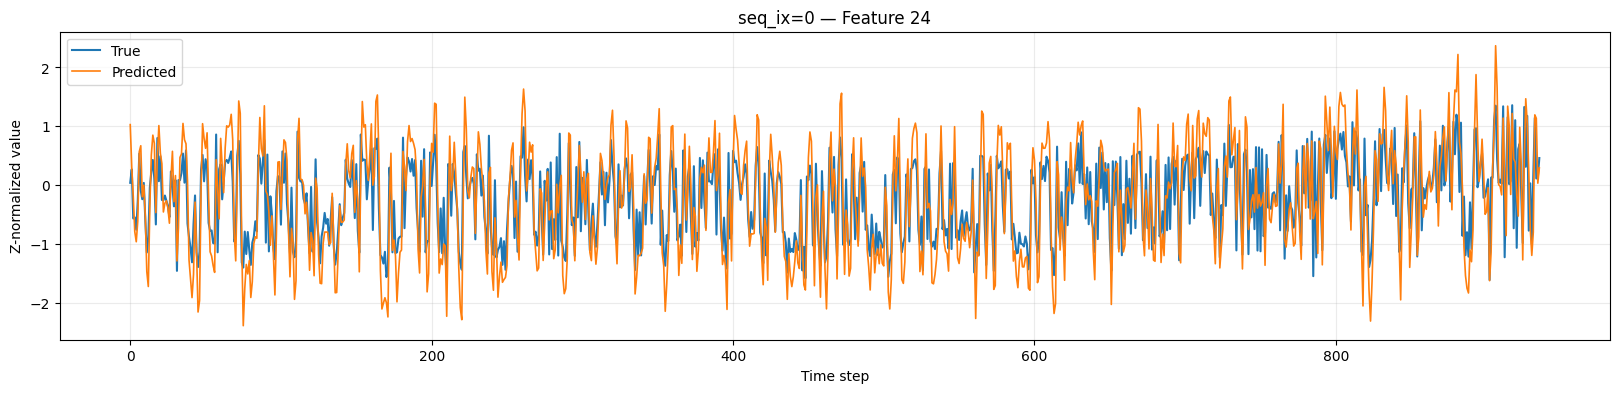

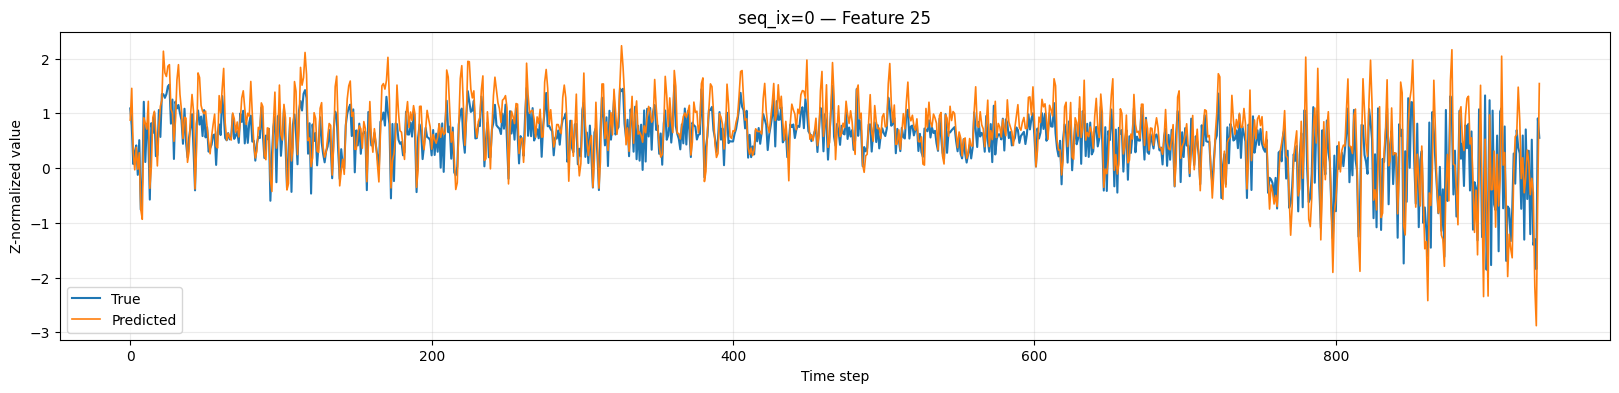

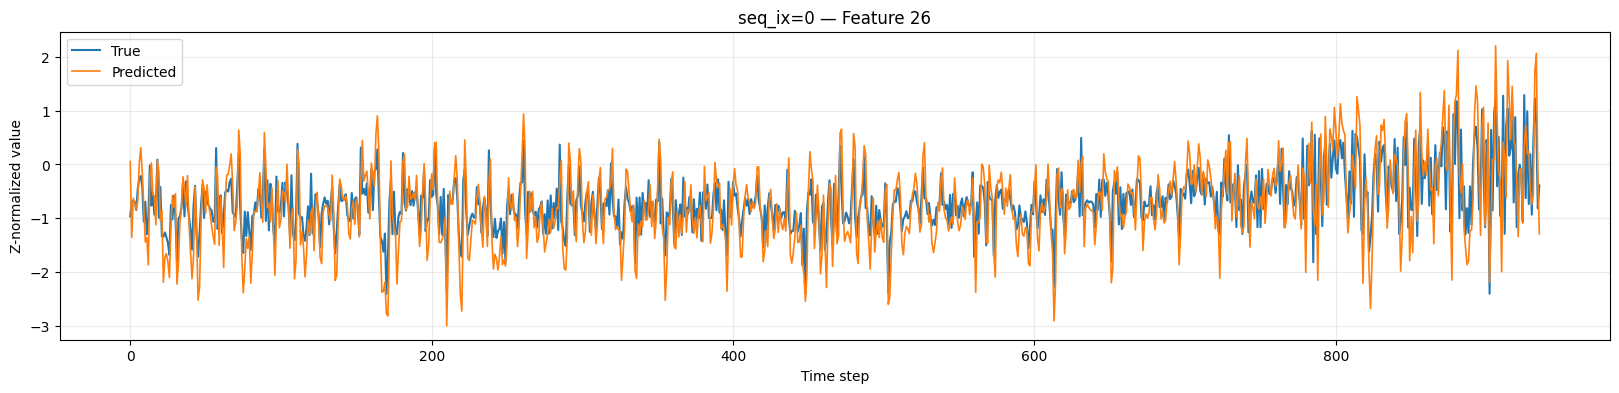

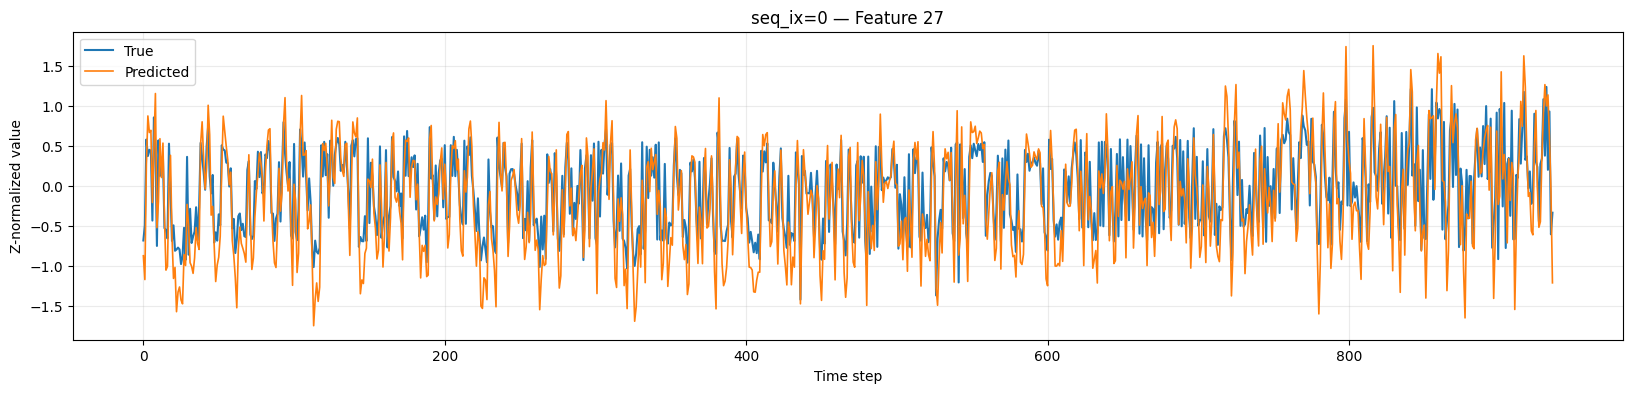

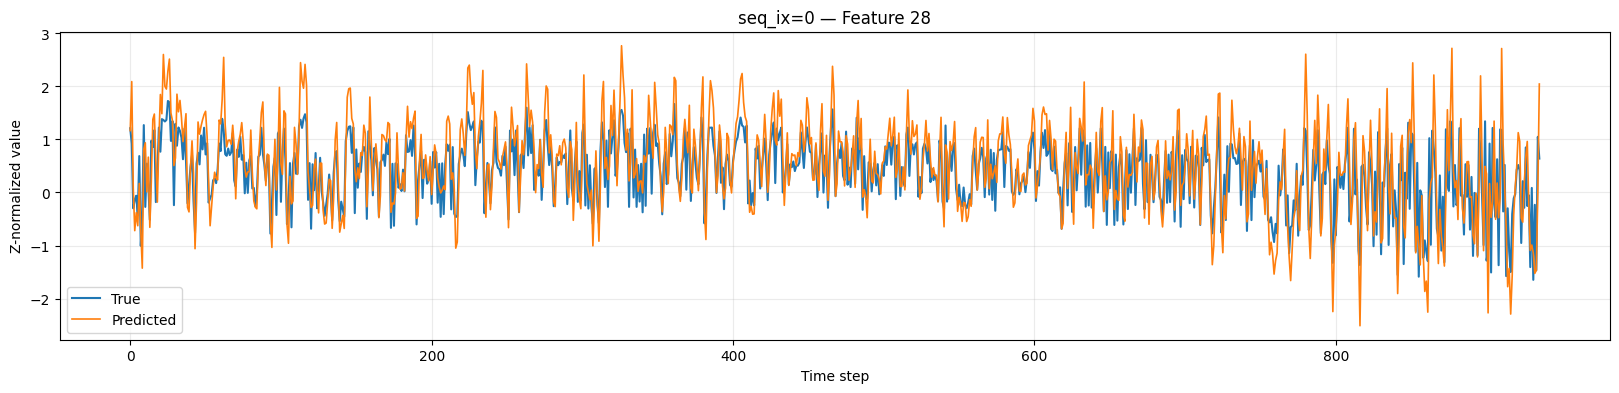

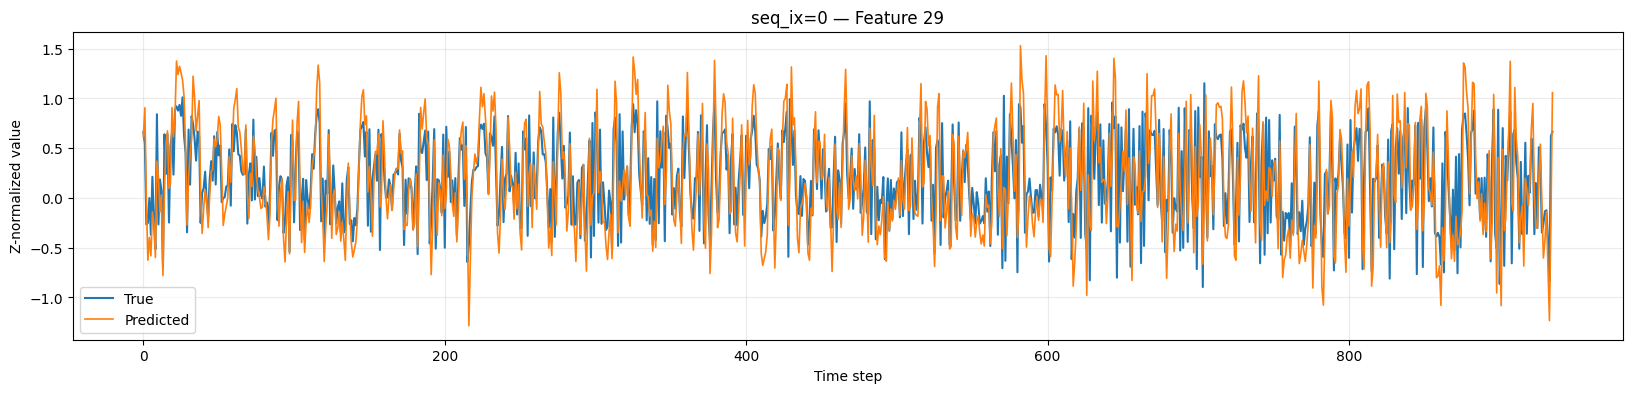

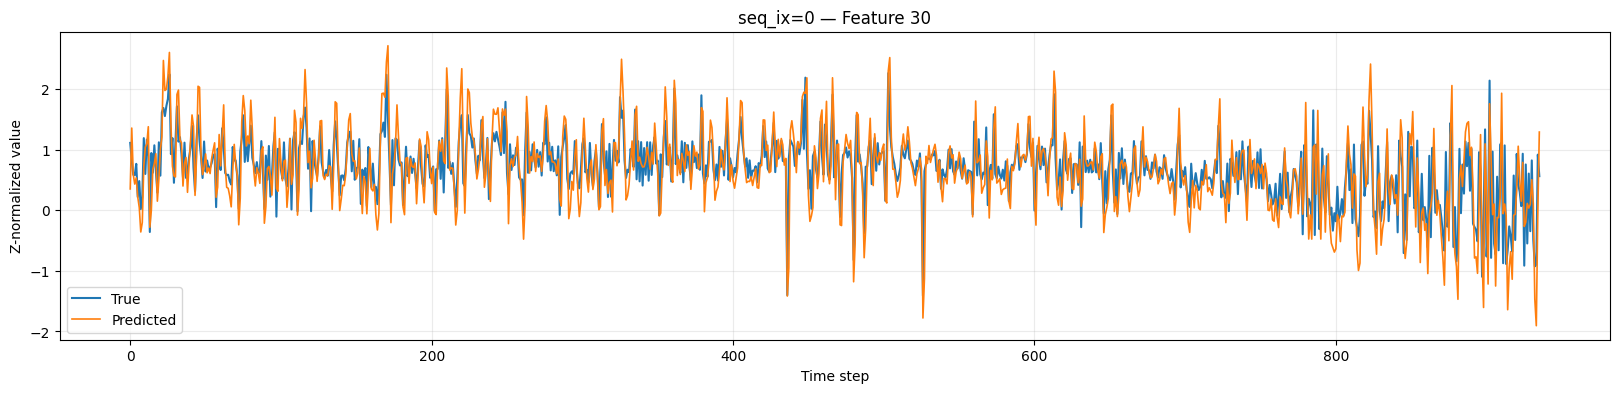

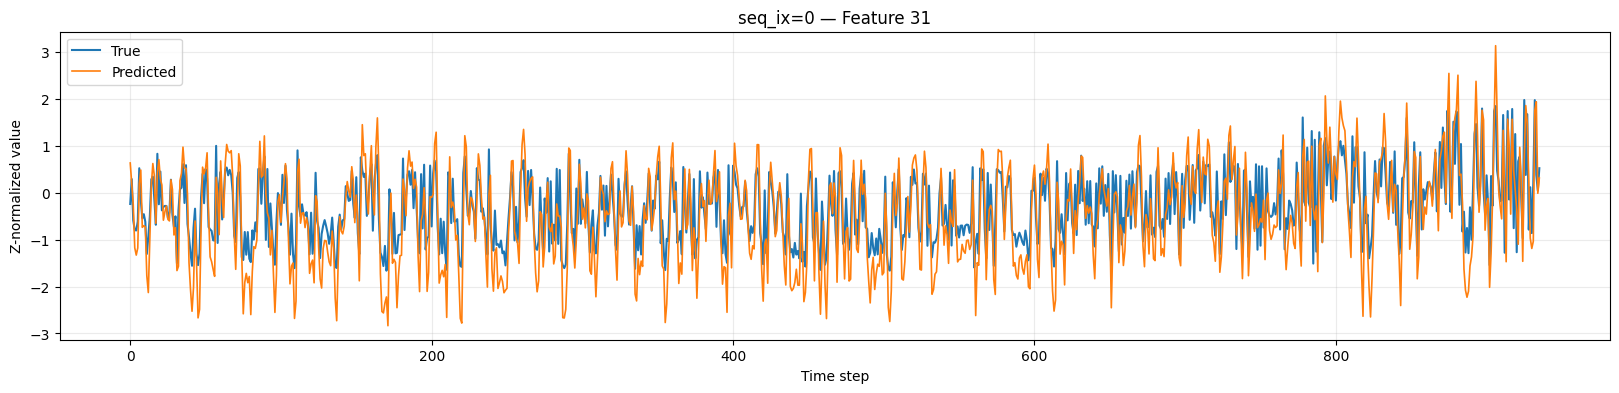


Done ✓


In [2]:
import os, sys, numpy as np, pandas as pd, torch, torch.nn as nn, matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CURRENT_DIR = os.getcwd()
sys.path.append(f"{CURRENT_DIR}/../..")
from utils import ScorerStepByStep


# ---------------- MODEL (same as scoring) ---------------- #
class PredictionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dim = 64
        self.output_dim = 32
        self.hidden_size = 64
        self.num_layers = 1

        self.lstm = nn.LSTM(self.input_dim, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.output_dim)

        weights_path = os.path.join(CURRENT_DIR, "lstm_weights.pt")
        self.load_state_dict(torch.load(weights_path, map_location=DEVICE))
        self.to(DEVICE)
        self.eval()

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1])     # delta_hat


# ---------------- Choose which seq_ix to visualize ---------------- #
seq_ix = 0           # <<< change this to inspect different sequences
feature_to_plot = None  # None = plot all 32; or set to index 0–31 to view one


# ---------------- Load dataset ---------------- #
scorer = ScorerStepByStep(f"{CURRENT_DIR}/../../datasets/train.parquet")
df = scorer.dataset
df_seq = df[df["seq_ix"] == seq_ix].sort_values("step_in_seq").reset_index(drop=True)

raw = df_seq.iloc[:, 3:35].to_numpy().astype(np.float32)
rm5 = pd.DataFrame(raw).rolling(5, min_periods=1).mean().to_numpy().astype(np.float32)
arr64 = np.concatenate([raw, rm5], axis=1).astype(np.float32)


# ---------------- Build sequences for prediction ---------------- #
SEQ_LEN = 64
X = []
y_true = []
for i in range(len(arr64) - SEQ_LEN):
    X.append(arr64[i:i+SEQ_LEN])
    y_true.append(raw[i+SEQ_LEN])          # true next raw (not delta)

X = torch.tensor(np.stack(X), dtype=torch.float32).to(DEVICE)
y_true = np.stack(y_true)


# ---------------- Predict ---------------- #
model = PredictionModel()
with torch.no_grad():
    delta_pred = model(X).cpu().numpy()
y_pred = y_true - delta_pred   # because your scoring uses raw_next = raw_t - delta_pred


# ---------------- Plot ---------------- #
def plot_feature(k):
    plt.figure(figsize=(20, 4))
    plt.plot(y_true[:, k], label="True", linewidth=1.5)
    plt.plot(y_pred[:, k], label="Predicted", linewidth=1.2)
    plt.title(f"seq_ix={seq_ix} — Feature {k}")
    plt.xlabel("Time step")
    plt.ylabel("Z-normalized value")
    plt.grid(alpha=0.25)
    plt.legend()
    plt.show()


if feature_to_plot is None:
    for k in range(32):
        plot_feature(k)
else:
    plot_feature(feature_to_plot)

print("\nDone ✓")
